In [17]:
import polars as pl
from nanomotif.binnary import data_processing

In [18]:
# class Args():
#     def __init__(self):
#         self.bin_motifs = "../data/datasets/fragmentation_benchmark_20kb_1800kb/bin-motifs.tsv"
#         self.contig_bins = "../data/real_communities/ZymoFecal/mmlong2_lite/tmp/binning/contig_bin.tsv"
#         self.assembly_file = "../data/real_communities/ZymoFecal/mmlong2_lite/results/mmlong2_lite_assembly.fasta"
#         self.motifs_scored = "../data/real_communities/ZymoFecal/nanomotif_binnary/motifs-scored-read-methylation.tsv"
#         self.min_valid_read_coverage = 3
#         self.mean_methylation_cutoff = 0.5
#         self.n_motif_bin_cutoff = 200
#         self.n_motif_contig_cutoff = 8
#         self.min_motif_comparisons = 2
#         self.save_scores = False
# #         self.threads = 1


# class Args():
#     def __init__(self):
#         self.bin_motifs = "../data/datasets/fragmentation_benchmark_20kb_1800kb/bin-motifs.tsv"
#         self.contig_bins = "../output/benchmarks/detect_contamination/2024-11-30_clustering_contamination_cluster_frac_l_0.6_filt17_minsamples3/fragmentation_benchmark_20kb_1800kb/benchmark_1_shuffle_1_contig_w_signal/contig_bin.tsv"
#         self.assembly_file = "../output/baseline/contamination_files/fragmentation_benchmark_20kb_1800kb/contamination_assembly.fasta"
#         self.motifs_scored = "../output/baseline/contamination_files/fragmentation_benchmark_20kb_1800kb/motifs-scored-read-methylation-3.tsv"
#         self.min_valid_read_coverage = 3
#         self.mean_methylation_cutoff = 0.5
#         self.n_motif_bin_cutoff = 200
#         self.n_motif_contig_cutoff = 8
#         self.min_motif_comparisons = 2
#         self.save_scores = False
#         self.threads = 1
        
class Args():
    def __init__(self):
        self.bin_motifs = "../data/datasets/fragmentation_benchmark_20kb_1800kb/bin-motifs.tsv"
        self.contig_bins = "../output/benchmarks/include_contigs/2024-12-02_read-level_clustering_rf_knn_lda/fragmentation_benchmark_20kb_1800kb/benchmark_9_remove_1_contig_w_signal/contig_bin.tsv"
        self.assembly_file = "../data/datasets/fragmentation_benchmark_20kb_1800kb/concatenated_assembly.fasta"
        self.motifs_scored = "../output/baseline/include_files/fragmentation_benchmark_20kb_1800kb/motifs-scored-read-methylation-1.tsv"
        self.min_valid_read_coverage = 3
        self.mean_methylation_cutoff = 0.5
        self.n_motif_bin_cutoff = 200
        self.n_motif_contig_cutoff = 8
        self.min_motif_comparisons = 2
        self.save_scores = False
        self.threads = 1

In [19]:
args = Args()
(
    bin_motifs,
    contig_bins,
) = data_processing.load_data(args)

In [20]:
assembly = data_processing.read_fasta(args.assembly_file)

In [21]:
contig_lengths = data_processing.find_contig_lengths(assembly)

In [ ]:
contig_methylation = pl.read_csv(
            args.motifs_scored, separator="\t", has_header = True
        )


In [7]:
import nanomotif.binnary.data_processing as dp
import hdbscan
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
contig_methylation = pl.read_csv(
            args.motifs_scored, separator="\t", has_header = True
        )
contig_methylation = contig_methylation\
        .filter(pl.col("mean_read_cov") >= args.min_valid_read_coverage)\
        .filter((pl.col("N_motif_obs").cast(pl.Float64) * pl.col("mean_read_cov")) >= 17)
        
contig_methylation = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )

contig_methylation = dp.impute_contig_methylation_within_bin(
        contig_methylation
    )
# INFO: It does not makes sense to find contamination in bins with a single contig
single_contig_bins = contig_methylation\
    .select(["bin", "contig"])\
    .unique()\
    .group_by("bin")\
    .agg(pl.col("contig").count().alias("n_contigs"))\
    .filter(pl.col("n_contigs") == 1)\
    .get_column("bin")

contig_methylation = contig_methylation\
    .filter(~pl.col("bin").is_in(single_contig_bins))

contig_names, matrix = dp.create_matrix(contig_methylation)

scaler = StandardScaler()
matrix = scaler.fit_transform(matrix)
original_features = matrix.shape[1]
print(f"Original number of features: {original_features}")

print("Applying PCA for feature decorrelation")
pca_variance=0.90
pca = PCA(n_components=pca_variance, svd_solver = "full")
matrix = pca.fit_transform(matrix)
reduced_components = matrix.shape[1]
print(f"PCA reduced the feature space from {original_features} to {reduced_components}")
print(f"Total explained variance by pca: {pca.explained_variance_ratio_.sum():.2f}")

n_bins = len(contig_methylation.get_column("bin").unique())

spectral = SpectralClustering(n_clusters=n_bins, affinity = 'nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(matrix)

kmeans = KMeans(n_clusters=n_bins, random_state=42)
kmeans_labels = kmeans.fit_predict(matrix)

dscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=2, metric = "euclidean", allow_single_cluster=False)
dscan_labels = dscan.fit_predict(matrix)

gmm = GaussianMixture(n_components=n_bins, covariance_type='full', random_state=42)
gmm.fit(matrix)
gmm_labels = gmm.predict(matrix)

agg = AgglomerativeClustering(n_clusters=n_bins, linkage = "ward")
agg_labels = agg.fit_predict(matrix)


contig_bin = contig_methylation\
    .select(["bin", "contig"])\
    .unique() 

results = pl.DataFrame({
                "contig": contig_names,
                "kmeans": kmeans_labels,
                "dscan": dscan_labels,
                "gmm": gmm_labels,
                "spectral": spectral_labels,
                "agg": agg_labels
            })\
            .join(contig_bin, on="contig")\
            .melt(
                id_vars = ["contig", "bin"],
                value_vars=["kmeans", "dscan", "gmm", "spectral", "agg"],
                value_name="cluster",
                variable_name="method"
            )




bin_size = contig_bin\
    .join(contig_lengths, on = "contig")\
    .group_by("bin")\
    .agg(
        pl.col("length").sum().alias("bin_length"),
        pl.col("contig").count().alias("n_contigs_bin")
    )

cluster_sizes = results\
    .join(contig_lengths, on="contig")\
    .group_by(["bin","method", "cluster"])\
    .agg(
        pl.col("contig").count().alias("n_contigs"),
        pl.col("length").sum().alias("cluster_length")
    )\
    .join(bin_size, on = "bin")\
    .with_columns(
        (pl.col("n_contigs") / pl.col("n_contigs_bin")).alias("fraction_contigs"),
        (pl.col("cluster_length") / pl.col("bin_length")).alias("fraction_length")
    )#\
    # .filter(pl.col("fraction_length")>0.60)

assigned_cluster = cluster_sizes\
    .group_by(["method","bin"])\
    .agg(
        pl.col("cluster_length").max().alias("cluster_length")
    )\
    .join(cluster_sizes, on = ["bin", "method","cluster_length"], how = "left")\
    .rename({
                "cluster": "bin_cluster"
            })\
    .drop(["cluster_length", "n_contigs"])



results = results\
    .join(assigned_cluster, on = ["bin", "method"])\
    .sort(["bin", "contig"])


contamination_contigs = results\
    .with_columns(
       (pl.col("bin_cluster") != pl.col("cluster")).cast(pl.Int8).alias("is_contaminant")
    )\
    .group_by(["contig"])\
    .agg(
        pl.col("is_contaminant").sum().alias("sum_predictions"),
    )\
    .filter(pl.col("sum_predictions") == 3)\
    .sort(["contig"])



Original number of features: 131
Applying PCA for feature decorrelation
PCA reduced the feature space from 131 to 31
Total explained variance by pca: 0.90


/home/bio.aau.dk/lh14io/.conda/envs/nanomotif_dev2/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [8]:
results\
    .filter(pl.col("contig").str.contains("contamination"))\
    .with_columns(
        (pl.col("cluster") != pl.col("bin_cluster")).cast(pl.Int8).alias("correct")
    )\
    .group_by(["method"])\
    .agg(
        pl.col("correct").sum().alias("n_correct"),
        pl.col("correct").count().alias("n_total"),
    )\
    .with_columns(
        (pl.col("n_correct") / pl.col("n_total")).alias("accuracy")
    )

method,n_correct,n_total,accuracy
str,i64,u32,f64
"""spectral""",25,28,0.892857
"""dscan""",28,28,1.0
"""agg""",28,28,1.0
"""gmm""",27,28,0.964286
"""kmeans""",27,28,0.964286


In [39]:
contamination_contigs = results\
    .with_columns(
       (pl.col("bin_cluster") != pl.col("cluster")).cast(pl.Int8).alias("is_contaminant")
    )

In [ ]:

bin_size = contig_bin\
    .join(contig_lengths, on = "contig")\
    .group_by("bin")\
    .agg(
        pl.col("length").sum().alias("bin_length"),
        pl.col("contig").count().alias("n_contigs_bin")
    )

cluster_sizes = results\
    .join(contig_lengths, on="contig")\
    .group_by(["bin","method", "cluster"])\
    .agg(
        pl.col("contig").count().alias("n_contigs"),
        pl.col("length").sum().alias("cluster_length")
    )\
    .join(bin_size, on = "bin")\
    .with_columns(
        (pl.col("n_contigs") / pl.col("n_contigs_bin")).alias("fraction_contigs"),
        (pl.col("cluster_length") / pl.col("bin_length")).alias("fraction_length")
    )#\
    # .filter(pl.col("fraction_length")>0.60)

assigned_cluster = cluster_sizes\
    .group_by(["method","bin"])\
    .agg(
        pl.col("cluster_length").max().alias("cluster_length")
    )\
    .join(cluster_sizes, on = ["bin", "cluster_length"], how = "left")\
    .rename({
                "cluster": "bin_cluster"
            })\
    .drop(["cluster_length", "n_contigs"])

results = results\
    .join(assigned_cluster, on = ["bin", "method"])\
    .pivot(
        values="cluster",
        index="contig",
        columns="method"
    )\
    .sort(["bin", "contig"])
    
print(results)

In [25]:
import polars as pl
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from nanomotif.binnary import data_processing as dp 

import hdbscan

contig_methylation = pl.read_csv(
            args.motifs_scored, separator="\t", has_header = True
        )
contig_methylation = contig_methylation\
        .filter(pl.col("mean_read_cov") >= args.min_valid_read_coverage)\
        .filter((pl.col("N_motif_obs").cast(pl.Float64) * pl.col("mean_read_cov")) >= 17)
        
contig_methylation = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )



binned_contig_methylation = dp.impute_contig_methylation_within_bin(
    contig_methylation
)

# bins_w_methylation = binned_contig_methylation\
#     .group_by(["bin", "motif_mod"])\
#     .agg(
#         pl.col("median").mean().alias("median")
#     )\
#     .with_columns(
#         (pl.col("median") > 0.25).cast(pl.Int8).alias("is_methylated")
#     )\
#     .filter(
#         pl.col("is_methylated") == 1
#     )\
#     .get_column("bin").unique()

# binned_contig_methylation = binned_contig_methylation\
#     .filter(pl.col("bin").is_in(bins_w_methylation))

unbinned_contig_methylation = dp.impute_unbinned_contigs(contig_methylation)

contig_names, matrix = dp.create_matrix(contig_methylation)

n_bins = len(binned_contig_methylation.get_column("bin").unique())

agg = AgglomerativeClustering(n_clusters=n_bins, linkage = "ward")
agg_labels = agg.fit_predict(matrix)

dscan = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=2, metric = "euclidean", allow_single_cluster=False)
dscan_labels = dscan.fit_predict(matrix)

gmm = GaussianMixture(n_components=n_bins, covariance_type='full', random_state=42)
gmm.fit(matrix)
gmm_labels = gmm.predict(matrix)

contig_bin = contig_methylation\
    .select(["bin", "contig"])\
    .unique() 

results = pl.DataFrame({
                "contig": contig_names,
                "agg": agg_labels,
                "dscan": dscan_labels,
                "gmm": gmm_labels
            })\
            .join(contig_bin, on="contig")\
            .melt(
                id_vars = ["contig", "bin"],
                value_vars=["agg", "dscan", "gmm"],
                value_name="cluster",
                variable_name="method"
            )

bin_size = contig_bin\
    .filter(pl.col("bin") != "unbinned")\
    .join(contig_lengths, on = "contig")\
    .group_by("bin")\
    .agg(
        pl.col("length").sum().alias("bin_length"),
        pl.col("contig").count().alias("n_contigs_bin")
    )

bin_cluster_sizes = results\
    .filter(pl.col("bin") != "unbinned")\
    .join(contig_lengths, on="contig")\
    .group_by(["bin","cluster", "method"])\
    .agg(
        pl.col("contig").count().alias("n_contigs"),
        pl.col("length").sum().alias("cluster_length")
    )\
    .join(bin_size, on = "bin")\
    .with_columns(
        (pl.col("n_contigs") / pl.col("n_contigs_bin")).alias("fraction_contigs"),
        (pl.col("cluster_length") / pl.col("bin_length")).alias("fraction_length")
    )

assigned_cluster = bin_cluster_sizes\
    .group_by(["bin", "method"])\
    .agg(
        pl.col("cluster_length").max().alias("cluster_length")
    )\
    .join(bin_cluster_sizes, on = ["bin", "method", "cluster_length"], how = "left")\
    .rename({
                "bin": "assigned_bin"
            })\
    .drop(["cluster_length", "n_contigs"])

unbinned_contigs_assigned_to_bin_cluster = results\
    .filter(pl.col("bin") == "unbinned")\
    .join(assigned_cluster, on = ["cluster", "method"])

uniquely_assigned_contigs = unbinned_contigs_assigned_to_bin_cluster\
    .group_by(["contig", "method"])\
    .agg(
        pl.col("bin").count().alias("n_assigned_bins"),
    )\
    .filter(pl.col("n_assigned_bins") == 1)\
    .group_by("contig")\
    .agg(
        pl.col("method").count().alias("n_consensus")
    )\
    .filter(pl.col("n_consensus") == 3)\
    .get_column("contig")

unbinned_contigs_assigned_to_bin_cluster = unbinned_contigs_assigned_to_bin_cluster\
    .with_columns(
        pl.when(pl.col("contig").is_in(uniquely_assigned_contigs))
            .then(True)
            .otherwise(False)
            .alias("assignment_is_unique")
    )\
    .sort(["contig"])

In [28]:
unbinned_contigs_assigned_to_bin_cluster\
    .sort(["contig"])

contig,bin,method,cluster,assigned_bin,bin_length,n_contigs_bin,fraction_contigs,fraction_length,assignment_is_unique
str,str,str,i64,str,i64,u32,f64,f64,bool
"""CVM07_Shewanella_oneidensis_co…","""unbinned""","""agg""",2,"""CVM07_Shewanella_oneidensis""",5080000,165,1.0,1.0,false
"""CVM07_Shewanella_oneidensis_co…","""unbinned""","""gmm""",6,"""CVM07_Shewanella_oneidensis""",5080000,165,1.0,1.0,false
"""CVM10_Pseudomonas_alcaliphila_…","""unbinned""","""gmm""",27,"""CVM10_Pseudomonas_alcaliphila""",5320000,177,0.960452,0.973684,true
"""CVM10_Pseudomonas_alcaliphila_…","""unbinned""","""agg""",24,"""CVM10_Pseudomonas_alcaliphila""",5320000,177,0.960452,0.973684,true
"""CVM10_Pseudomonas_alcaliphila_…","""unbinned""","""dscan""",45,"""CVM10_Pseudomonas_alcaliphila""",5320000,177,0.937853,0.958647,true
…,…,…,…,…,…,…,…,…,…
"""m_ruber_contig_1_sliding_28400…","""unbinned""","""gmm""",14,"""m_ruber""",3060000,64,1.0,1.0,true
"""m_ruber_contig_1_sliding_28400…","""unbinned""","""agg""",19,"""m_ruber""",3060000,64,1.0,1.0,true
"""m_ruber_contig_1_sliding_28400…","""unbinned""","""dscan""",1,"""m_ruber""",3060000,64,1.0,1.0,true


In [38]:
unbinned_contigs_assigned_to_bin_cluster\
    .with_columns(
        pl.col("contig").str.replace("_contig.*", "").alias("bin_truth")
    )\
    .with_columns(
        (pl.col("bin_truth") == pl.col("assigned_bin")).cast(pl.Int8).alias("correct")
    )\
    .select(["contig", "assignment_is_unique", "correct"])\
    .unique(subset=["contig"])\
    .group_by(["assignment_is_unique"])\
    .agg(
        pl.col("correct").sum().alias("n_correct"),
        pl.col("correct").count().alias("n_total"),
    )

assignment_is_unique,n_correct,n_total
bool,i64,u32
false,9,13
true,15,15


In [ ]:
import polars as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from nanomotif.binnary import data_processing as dp 

contig_methylation = pl.read_csv(
            args.motifs_scored, separator="\t", has_header = True
        )
contig_methylation = contig_methylation\
        .filter(pl.col("mean_read_cov") >= args.min_valid_read_coverage)\
        .filter((pl.col("N_motif_obs").cast(pl.Float64) * pl.col("mean_read_cov")) >= 24)
        
contig_methylation = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )

contig_bin = contig_methylation\
    .select(["bin", "contig"])\
    .unique() 

binned_contig_methylation = dp.impute_contig_methylation_within_bin(
    contig_methylation
)




binned_contig_names, binned_matrix = dp.create_matrix(binned_contig_methylation)

scaler = StandardScaler()
binned_matrix = scaler.fit_transform(binned_matrix)

pca_variance=0.90
pca = PCA(n_components=pca_variance, svd_solver = "full")
binned_matrix = pca.fit_transform(binned_matrix)


bins = pl.DataFrame({
    "contig": binned_contig_names,
})\
    .join(contig_bin, on = "contig", how = "left")



assert binned_contig_names.to_list() == bins.get_column("contig").to_list()


unbinned_contig_methylation = dp.impute_unbinned_contigs(contig_methylation)
unbinned_contig_feature_complete = pl.DataFrame({
    "contig": unbinned_contig_methylation.get_column("contig").unique()
})\
    .join(pl.DataFrame({"motif_mod": binned_contig_methylation.get_column("motif_mod").unique()}), how = "cross")\
    .join(unbinned_contig_methylation, on = ["contig", "motif_mod"], how = "left")


unbinned_contig_names, unbinned_matrix = dp.create_matrix(unbinned_contig_methylation)
unbinned_matrix = scaler.transform(unbinned_matrix)
unbinned_matrix = pca.transform(unbinned_matrix)

lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel="rbf", probability=True, random_state=42, class_weight="balanced")

lda_pred = lda.fit(binned_matrix, bins.get_column("bin"))
lda_labels = lda_pred.predict(unbinned_matrix)
lda_prob = lda_pred.predict_proba(unbinned_matrix).max(axis = 1)

knn_pred = knn.fit(binned_matrix, bins.get_column("bin"))
knn_labels = knn_pred.predict(unbinned_matrix)
knn_prob = knn_pred.predict_proba(unbinned_matrix).max(axis = 1)

rf_pred = rf.fit(binned_matrix, bins.get_column("bin"))
rf_labels = rf_pred.predict(unbinned_matrix)
rf_prob = rf_pred.predict_proba(unbinned_matrix).max(axis = 1)

svm_pred = svm.fit(binned_matrix, bins.get_column("bin"))
svm_labels = svm_pred.predict(unbinned_matrix)
svm_prob = svm_pred.predict_proba(unbinned_matrix).max(axis = 1)


rf_df = pl.DataFrame({
    "contig": unbinned_contig_names,
    "method": "rf",
    "pred": rf_labels,
    "prob": rf_prob
})

knn_df = pl.DataFrame({
    "contig": unbinned_contig_names,
    "method": "knn",
    "pred": knn_labels,
    "prob": knn_prob
})

svm_df = pl.DataFrame({
    "contig": unbinned_contig_names,
    "method": "svm",
    "pred": svm_labels,
    "prob": svm_prob
})

lda_df = pl.DataFrame({
    "contig": unbinned_contig_names,
    "method": "lda",
    "pred": lda_labels,
    "prob": lda_prob
})

method_df = pl.concat([rf_df, knn_df, svm_df, lda_df])


results = pl.DataFrame({
                "contig": unbinned_contig_names,
                "svm": svm_labels,
                "knn": knn_labels,
                "rf": rf_labels,
            })\
            .join(contig_bin, on="contig")\
            .melt(
                id_vars = ["contig", "bin"],
                value_vars=["svm", "knn", "rf"],
                value_name="assigned_bin",
                variable_name="method"
            )
columns = ["contig", "bin", "assigned_bin", "method", "prob", "mean_prob", "confidence"]

n_assigned_bins = results\
    .group_by(["contig"])\
    .agg(
        pl.col("assigned_bin").n_unique().alias("n_assigned_bins")
    )


high_confidence_assignements = results\
    .filter(pl.col("contig").is_in(n_assigned_bins.filter(pl.col("n_assigned_bins") == 1).get_column("contig")))


high_mean_prob = high_confidence_assignements\
    .join(method_df, on = ["contig", "method"])\
    .group_by(["contig"])\
    .agg(
        pl.col("prob").mean().alias("mean_prob")
    )


high_confidence_assignements = high_confidence_assignements\
    .join(method_df, on = ["contig", "method"])\
    .join(high_mean_prob, on = ["contig"])\
    .with_columns(
        pl.when(pl.col("mean_prob") > 0.8).then(pl.lit("high_confidence")).otherwise(pl.lit("medium_confidence")).alias("confidence")
    )\
    .sort(["contig"])\
    .select(columns)



low_confidence_assignments = results\
    .filter(pl.col("contig").is_in(n_assigned_bins.filter(pl.col("n_assigned_bins") == 2).get_column("contig")))

low_confidence_classification = low_confidence_assignments\
    .group_by(["contig", "assigned_bin"])\
    .agg(
        pl.col("assigned_bin").count().alias("n_assigned_bins"),
    )\
    .filter(pl.col("n_assigned_bins") == 2)\
    .drop(["n_assigned_bins"])


low_confidence_assignments = low_confidence_classification\
    .join(low_confidence_assignments, on = ["contig", "assigned_bin"])\
    .join(method_df, on = ["contig", "method"])
    

low_mean_prob = low_confidence_assignments\
    .group_by(["contig"])\
    .agg(
        pl.col("prob").mean().alias("mean_prob")
    )

low_confidence_assignments = low_confidence_assignments\
    .join(low_mean_prob, on = ["contig"])\
    .with_columns(
        pl.lit("low_confidence").alias("confidence")
    )\
    .sort(["contig"])\
    .select(columns)


assigned_contigs = pl.concat([high_confidence_assignements, low_confidence_assignments])

shape: (3, 4)
┌─────────────────────────────────┬──────────┬────────┬───────────────────────────────┐
│ contig                          ┆ bin      ┆ method ┆ assigned_bin                  │
│ ---                             ┆ ---      ┆ ---    ┆ ---                           │
│ str                             ┆ str      ┆ str    ┆ str                           │
╞═════════════════════════════════╪══════════╪════════╪═══════════════════════════════╡
│ CVM73_Kangiella_aquimarina_con… ┆ unbinned ┆ svm    ┆ CVM69_Comamonas_testosteroni  │
│ CVM73_Kangiella_aquimarina_con… ┆ unbinned ┆ knn    ┆ CVM59_Sphingomonas_echinoides │
│ CVM73_Kangiella_aquimarina_con… ┆ unbinned ┆ rf     ┆ CVM69_Comamonas_testosteroni  │
└─────────────────────────────────┴──────────┴────────┴───────────────────────────────┘


In [ ]:
method_df

contig,method,pred,prob
str,str,str,f64
"""CVM07_Shewanella_oneidensis_co…","""knn""","""CVM07_Shewanella_oneidensis""",1.0
"""CVM07_Shewanella_oneidensis_co…","""lda""","""CVM07_Shewanella_oneidensis""",1.0
"""CVM07_Shewanella_oneidensis_co…","""rf""","""CVM07_Shewanella_oneidensis""",0.49
"""CVM07_Shewanella_oneidensis_co…","""svm""","""CVM07_Shewanella_oneidensis""",0.708395
"""CVM10_Pseudomonas_alcaliphila_…","""knn""","""CVM10_Pseudomonas_alcaliphila""",1.0
…,…,…,…
"""m_ruber_contig_1_sliding_29600…","""svm""","""m_ruber""",0.633412
"""p_thermoglucosidasius_contig_1…","""knn""","""p_thermoglucosidasius""",1.0
"""p_thermoglucosidasius_contig_1…","""lda""","""p_thermoglucosidasius""",1.0


In [10]:
high_confidence_assignements.columns

['contig',
 'bin',
 'method',
 'assigned_bin',
 'pred',
 'prob',
 'mean_prob',
 'confidence']

In [11]:
low_confidence_assignments.columns

['contig',
 'assigned_bin',
 'bin',
 'method',
 'pred',
 'prob',
 'mean_prob',
 'confidence']

contig,method,pred,prob
str,str,str,f64
"""CVM07_Shewanella_oneidensis_co…","""rf""","""CVM07_Shewanella_oneidensis""",0.46
"""CVM10_Pseudomonas_alcaliphila_…","""rf""","""CVM10_Pseudomonas_alcaliphila""",0.78
"""CVM22_Bacillus_licheniformis_c…","""rf""","""CVM22_Bacillus_licheniformis""",0.76
"""CVM23_Alkalihalobacillus_claus…","""rf""","""CVM23_Alkalihalobacillus_claus…",0.78
"""CVM26_Chromohalobacter_canaden…","""rf""","""CVM26_Chromohalobacter_canaden…",0.42
…,…,…,…
"""DSMZ6575-Sphaerotilus_natans_c…","""svm""","""DSMZ6575-Sphaerotilus_natans""",0.546358
"""DSMZ6589-Thermanaerovibrio_aci…","""svm""","""DSMZ2661-Methanocaldococcus_ja…",0.255526
"""e_coli_k12_contig_3_sliding_31…","""svm""","""e_coli_k12""",0.716811


In [12]:
results\
    .with_columns(
        pl.col("contig").str.replace(r"_contig_.*", "").alias("bin_truth")
    )\
    .with_columns(
        (pl.col("cluster") == pl.col("bin_truth")).cast(pl.Int8).alias("correct")
    )\
    .group_by(["method"])\
    .agg(
        pl.col("correct").sum().alias("n_correct"),
        pl.col("correct").count().alias("n_total"),
    )\
    .with_columns(
        (pl.col("n_correct") / pl.col("n_total")).alias("accuracy")
    )


method,n_correct,n_total,accuracy
str,i64,u32,f64
"""svm""",26,28,0.928571
"""knn""",26,28,0.928571
"""rf""",28,28,1.0
"""lda""",26,28,0.928571


In [43]:
bins\
    .group_by(["bin"])\
    .agg(
        pl.col("contig").count().alias("n_contigs")
    )

bin,n_contigs
str,u32
"""CVM81_Azospirillum_brasilense""",269
"""DSMZ11109-Desulfobacca_acetoxi…",74
"""CVM38_Duganella_zoogloeoides""",226
"""DSMZ2380-Pelobacter_carbinolic…",93
"""CVM10_Pseudomonas_alcaliphila""",177
…,…
"""m_ruber""",64
"""DSMZ13772-Salmonella_bongori""",133
"""CVM60_Rhodopseudomonas_palustr…",175


In [ ]:
import polars as pl
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from nanomotif.binnary import data_processing as dp 


contig_methylation = pl.read_csv(
            args.motifs_scored, separator="\t", has_header = True
        )
contig_methylation = contig_methylation\
        .filter(pl.col("mean_read_cov") >= args.min_valid_read_coverage)\
        .filter((pl.col("N_motif_obs").cast(pl.Float64) * pl.col("mean_read_cov")) >= 17)
        
contig_methylation = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )

contig_bin = contig_methylation\
    .select(["bin", "contig"])\
    .unique() 

binned_contig_methylation = dp.impute_contig_methylation_within_bin(
    contig_methylation
)

# bins_w_methylation = binned_contig_methylation\
#     .group_by(["bin", "motif_mod"])\
#     .agg(
#         pl.col("median").mean().alias("median")
#     )\
#     .with_columns(
#         (pl.col("median") > 0.25).cast(pl.Int8).alias("is_methylated")
#     )\
#     .filter(
#         pl.col("is_methylated") == 1
#     )\
#     .get_column("bin").unique()

# binned_contig_methylation = binned_contig_methylation\
#     .filter(pl.col("bin").is_in(bins_w_methylation))

binned_contig_names, binned_matrix = dp.create_matrix(binned_contig_methylation)
bins = pl.DataFrame({
    "contig": binned_contig_names,
})\
    .join(contig_bin, on = "contig", how = "left")


unbinned_contig_methylation = dp.impute_unbinned_contigs(contig_methylation)
unbinned_contig_names, unbinned_matrix = dp.create_matrix(unbinned_contig_methylation)

lda_grid_param = {
    "solver": ["svd", "lsqr", "eigen"],
    "n_components": [2, 3, 4, 5]
}
lda_grid = RandomizedSearchCV(LinearDiscriminantAnalysis(), lda_grid_param, n_iter = 5, cv=5, n_jobs=args.threads)
lda_grid.fit(binned_matrix, bins.get_column("bin"))
lda_best = lda_grid.best_estimator_


knn_grid_param = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}
knn_grid = RandomizedSearchCV(KNeighborsClassifier(), knn_grid_param, n_iter = 5, cv=5, n_jobs=args.threads)
knn_grid.fit(binned_matrix, bins.get_column("bin"))
knn_best = knn_grid.best_estimator_

rf_grid_param = {
    "n_estimators": [100, 200, 300, 400],
    "criterion": ["gini", "entropy"],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
}
rf_grid = RandomizedSearchCV(RandomForestClassifier(), rf_grid_param, n_iter = 5, cv=5, n_jobs=args.threads)
rf_grid.fit(binned_matrix, bins.get_column("bin"))
rf_best = rf_grid.best_estimator_

voting_clf = VotingClassifier(estimators=[
    ('lda', lda_best),
    ('knn', knn_best),
    ('rf', rf_best)
], voting='soft')

voting_clf.fit(binned_matrix, bins.get_column("bin"))
voting_pred = voting_clf.predict(unbinned_matrix)
voting_prob = voting_clf.predict_proba(unbinned_matrix).max(axis = 1)



results = pl.DataFrame({
                "contig": unbinned_contig_names,
                "classification": voting_pred,
                "confidence": voting_prob
            })#\
            # .join(contig_bin, on="contig")\
            # .melt(
            #     id_vars = ["contig", "bin"],
            #     value_vars=["lda", "knn", "rf"],
            #     value_name="cluster",
            #     variable_name="method"
            # )
print(results)

# n_assigned_bins = results\
#     .group_by(["contig"])\
#     .agg(
#         pl.col("cluster").n_unique().alias("n_assigned_bins"),
#     )

# high_confidence_assignements = results\
#     .filter(pl.col("contig").is_in(n_assigned_bins.filter(pl.col("n_assigned_bins") == 1).get_column("contig")))\
#     .with_columns(
#         pl.lit("high_confidence").alias("confidence"),
#         pl.col("cluster").alias("assignment")
#     )\
#     .sort(["contig"])



# medium_confidence = results\
#     .filter(pl.col("contig").is_in(n_assigned_bins.filter(pl.col("n_assigned_bins") == 2).get_column("contig")))\
#     .group_by(["contig", "cluster"])\
#     .agg(
#         pl.col("cluster").count().alias("n_assigned_bins"),
#     )\
#     .filter(pl.col("n_assigned_bins") == 2)\
#     .with_columns(
#         pl.lit("medium_confidence").alias("confidence"),
#         pl.col("cluster").alias("assignment")
#     )\
#     .select(["contig", "cluster", "confidence", "assignment"])


# medium_confidence_assignements = results\
#     .join(medium_confidence, on = ["contig", "cluster"], how = "left")\
#     .filter(pl.col("confidence").is_not_null())


# assigned_contigs = pl.concat([high_confidence_assignements, medium_confidence_assignements])

contig,bin,lda_prob,method,cluster,bin_truth,is_correct
str,str,f64,str,str,str,i8
"""DSMZ107007-Anabaena_variabilis…","""unbinned""",1.0,"""lda""","""CVM62_Streptomyces_albidoflavu…","""DSMZ107007-Anabaena_variabilis""",0
"""DSMZ6589-Thermanaerovibrio_aci…","""unbinned""",1.0,"""lda""","""CVM62_Streptomyces_albidoflavu…","""DSMZ6589-Thermanaerovibrio_aci…",0
"""DSMZ20745-Sphaerobacter_thermo…","""unbinned""",1.0,"""lda""","""CVM76_Acidithiobacillus_thioox…","""DSMZ20745-Sphaerobacter_thermo…",0
"""CVM73_Kangiella_aquimarina_con…","""unbinned""",1.0,"""lda""","""CVM73_Kangiella_aquimarina""","""CVM73_Kangiella_aquimarina""",1
"""CVM76_Acidithiobacillus_thioox…","""unbinned""",1.0,"""lda""","""CVM62_Streptomyces_albidoflavu…","""CVM76_Acidithiobacillus_thioox…",0
…,…,…,…,…,…,…
"""CVM23_Alkalihalobacillus_claus…","""unbinned""",1.0,"""nb""","""CVM68_Rhodococcus_opacus""","""CVM23_Alkalihalobacillus_claus…",0
"""CVM69_Comamonas_testosteroni_c…","""unbinned""",0.99707,"""nb""","""CVM68_Rhodococcus_opacus""","""CVM69_Comamonas_testosteroni""",0
"""CVM07_Shewanella_oneidensis_co…","""unbinned""",1.0,"""nb""","""CVM68_Rhodococcus_opacus""","""CVM07_Shewanella_oneidensis""",0


In [ ]:
results\
    .with_columns(
        pl.col("contig").str.replace(r"_contig_.*", "").alias("bin_truth")
    )\
    .with_columns(
        (pl.col("classification") == pl.col("bin_truth")).cast(pl.Int8).alias("correct"),
        pl.lit("voting_classifier").alias("method")
    )\
    .group_by("method")\
    .agg(
        pl.col("correct").sum().alias("n_correct"),
        pl.col("correct").count().alias("n_total"),
    )\
    .with_columns(
        (pl.col("n_correct") / pl.col("n_total")).alias("accuracy")
    )

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

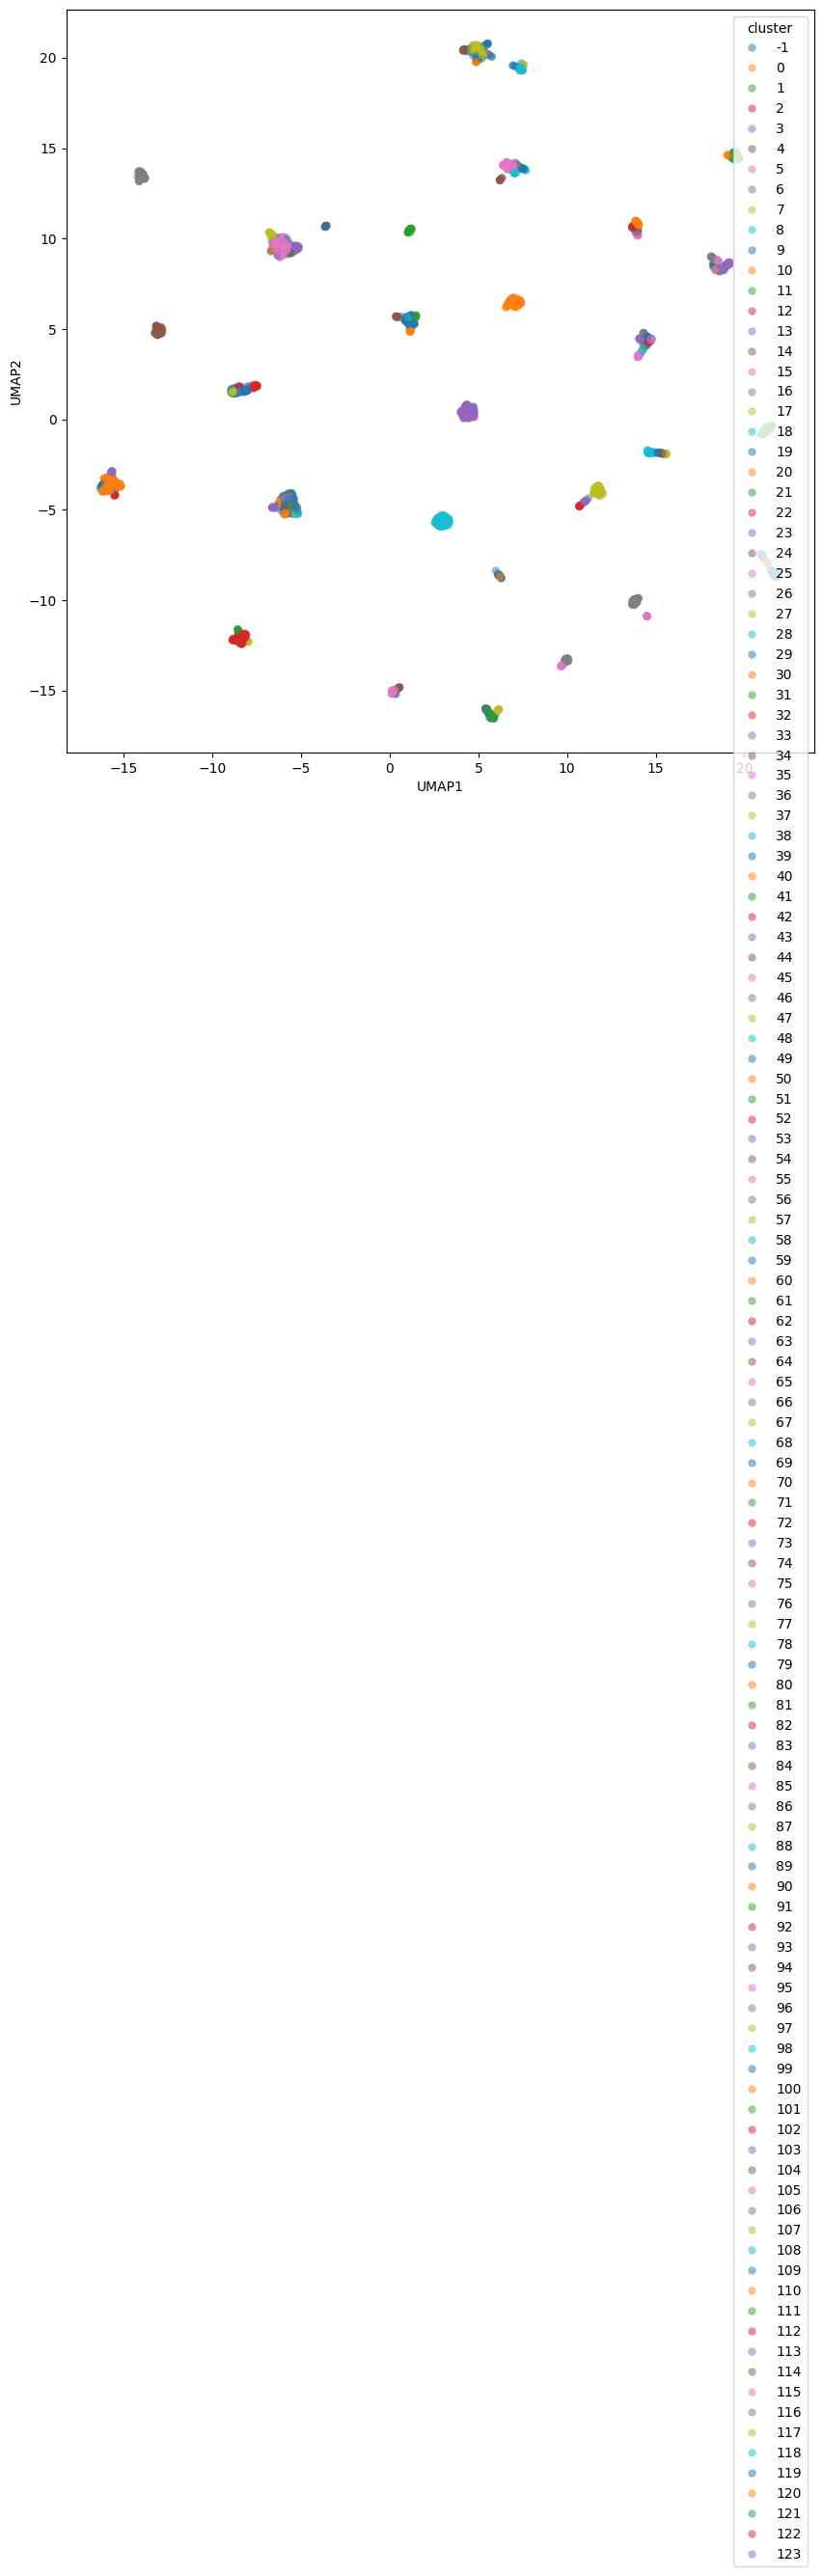

In [ ]:
# plot umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["cluster"] = labels
embedding_df["bin"] = contig_methylation.select("bin").to_pandas()
embedding_df = embedding_df.merge(bin_size.to_pandas(), on="bin")
embedding_df["fraction_contigs"] = embedding_df["n_contigs_bin"] / embedding_df["n_contigs_bin"].sum()
embedding_df["fraction_length"] = embedding_df["bin_length"] / embedding_df["bin_length"].sum()

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    data=embedding_df,
    palette="tab10",
    linewidth=0,
    alpha=0.5,
)

In [62]:
import hdbscan
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis




n_motifs_per_contig = list(range(1, 2, 1))
results = pl.DataFrame()
for n in n_motifs_per_contig:
        
    
    contig_methylation_bin = contig_methylation#\
        # .filter(pl.col("mean_read_cov") > 1)\
        # .filter((pl.col("N_motif_obs").cast(pl.Float64) * pl.col("mean_read_cov")) >= n)    
    
    contig_methylation_bin = data_processing.add_bin(
                contig_methylation_bin,
                contig_bins
            )

    bins_with_single_contigs = contig_methylation_bin\
        .select(["bin", "contig"])\
        .unique()\
        .group_by("bin")\
        .agg(pl.col("contig").count().alias("n_contigs"))\
        .filter(pl.col("n_contigs") == 1)


    contig_methylation_bin = contig_methylation_bin\
        .filter(~pl.col("bin").is_in(bins_with_single_contigs.get_column("bin")))
    
    
    binned_contig_methylation_imputed = data_processing.impute_contig_methylation_within_bin(
                contig_methylation_bin,
                args
            )


    contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)


    clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5, metric="euclidean")
    hdbscan_labels = clusterer.fit_predict(matrix)
    
    res = pl.DataFrame({
        "contig": contig_names,
        "cluster": hdbscan_labels,
        "n_motifs": str(n)
    })
    results = pl.concat([results, res])

In [63]:

n_contigs_per_bin = contig_bins\
    .join(contig_lengths, on="contig")\
    .group_by(["bin"])\
    .agg(
        pl.col("contig").count().alias("n_contigs_bin"),
        pl.col("length").sum().alias("bin_length")
    )



bins_clusters = results\
    .join(contig_bins, on="contig")\
    .join(contig_lengths, on="contig")\
    .group_by(["n_motifs", "bin", "cluster"])\
    .agg(
        pl.col("contig").count().alias("n_contigs"),
        pl.col("length").sum().alias("cluster_length")
    )\
    .join(n_contigs_per_bin, on="bin")\
    .with_columns(
        (pl.col("n_contigs") / pl.col("n_contigs_bin")).alias("fraction_contigs"),
        (pl.col("cluster_length") / pl.col("bin_length")).alias("fraction_length")
    )#\
    #.filter(pl.col("cl"))

bins_clusters_max = bins_clusters\
    .group_by(["bin", "n_motifs"])\
    .agg(
        pl.col("cluster_length").max().alias("cluster_length")
    )\
    .join(bins_clusters, on=["n_motifs","bin", "cluster_length"], how = "left")
        


# hdbscan no preprocessing 0.9857949960076685
# lda (n_components=5) hdbscan 0.8381017087715615
# lda (n_components=20) hdbscan 0.892322772261585


In [67]:
bins_clusters_max

bin,n_motifs,cluster_length,cluster,n_contigs,n_contigs_bin,bin_length,fraction_contigs,fraction_length
str,str,i64,i64,u32,u32,i64,f64,f64
"""p_thermoglucosidasius""","""1""",3960000,5,109,109,3960000,1.0,1.0
"""DSMZ6575-Sphaerotilus_natans""","""1""",4680000,4,145,145,4680000,1.0,1.0
"""CVM32_Halomonas_alkaliphila""","""1""",4140000,19,118,118,4140000,1.0,1.0
"""CVM77_Acidiphilium_acidophilum""","""1""",4320000,18,127,128,4340000,0.9921875,0.995392
"""CVM26_Chromohalobacter_canaden…","""1""",3580000,14,90,90,3580000,1.0,1.0
…,…,…,…,…,…,…,…,…
"""CVM60_Rhodopseudomonas_palustr…","""1""",5280000,24,175,179,5360000,0.977654,0.985075
"""DSMZ2661-Methanocaldococcus_ja…","""1""",1700000,1,85,85,1700000,1.0,1.0
"""CVM07_Shewanella_oneidensis""","""1""",5100000,11,166,166,5100000,1.0,1.0


In [64]:
bins_clusters_max\
    .group_by("n_motifs")\
    .agg(
        pl.col("fraction_contigs").mean().alias("fraction_contigs"),
        pl.col("fraction_length").mean().alias("fraction_length")
    )\
    .with_columns(
        pl.col("n_motifs").cast(pl.Int64),
    )\
    .sort("n_motifs")

n_motifs,fraction_contigs,fraction_length
i64,f64,f64
1,0.982939,0.989675


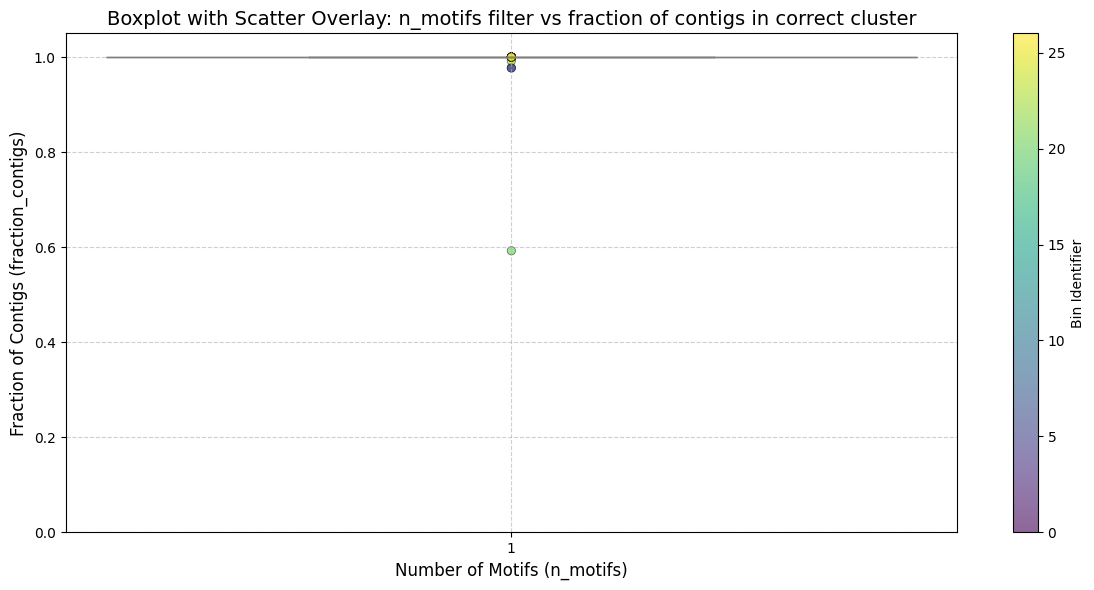

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your dataframe
data = bins_clusters_max.to_pandas()
data.sort_values(by='n_motifs', inplace=True)

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot
sns.boxplot(
    x="n_motifs", 
    y="fraction_contigs", 
    data=data, 
    ax=ax, 
    color='lightgray', 
    width=0.6,
    showfliers=False # Hide outliers to avoid clutter
)

# Overlay the scatterplot
unique_bins = data["bin"].unique()
bin_to_color = {bin: i for i, bin in enumerate(unique_bins)}
colors = data["bin"].map(lambda bin: bin_to_color[bin])

scatter = ax.scatter(
    x=data["n_motifs"], 
    y=data["fraction_contigs"], 
    c=colors, 
    alpha=0.6, 
    cmap='viridis', # Change color palette as needed
    edgecolor='k', 
    linewidth=0.5
)

# Improve aesthetics
ax.set_title("Boxplot with Scatter Overlay: n_motifs filter vs fraction of contigs in correct cluster", fontsize=14)
ax.set_xlabel("Number of Motifs (n_motifs)", fontsize=12)
ax.set_ylabel("Fraction of Contigs (fraction_contigs)", fontsize=12)
ax.set_ylim(0, 1.05) # Set y-axis limits to [0, 1]
ax.grid(True, linestyle='--', alpha=0.6)

# Optional: Add a colorbar for bin colors
cbar = plt.colorbar(scatter, ax=ax, label='Bin Identifier', orientation='vertical')

# Display the plot
plt.tight_layout()
plt.show()

In [25]:
data

,n_motifs,bin,cluster,n_contigs,n_contigs_bin,fraction_contigs
0,1,CVM69_Comamonas_testosteroni,24,300,300,1.000000
1,1,DSMZ6575-Sphaerotilus_natans,4,234,234,1.000000
2,1,DSMZ13772-Salmonella_bongori,14,223,223,1.000000
3,1,DSMZ107007-Anabaena_variabilis,0,358,358,1.000000
4,1,CVM23_Alkalihalobacillus_clausii,19,224,224,1.000000
...,...,...,...,...,...,...
539,15,DSMZ13772-Salmonella_bongori,20,21,223,0.094170
540,15,CVM62_Streptomyces_albidoflavus,-1,57,356,0.160112
541,15,CVM22_Bacillus_licheniformis,34,211,211,1.000000
542,15,CVM32_Halomonas_alkaliphila,23,9,207,0.043478


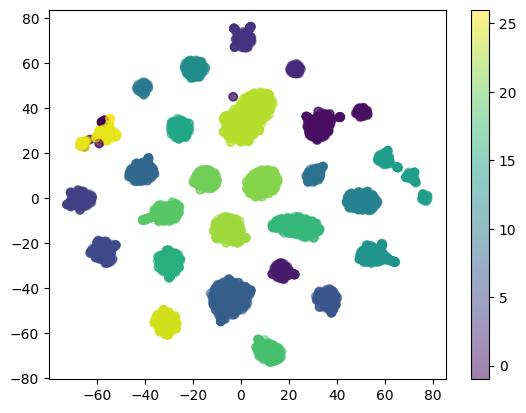

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, metric="euclidean")
tse_results = tsne.fit_transform(matrix)

plt.scatter(tse_results[:, 0], tse_results[:, 1], c=hdbscan_labels, alpha=0.5)
# show colorscale
plt.colorbar()
plt.show()


In [12]:
from sklearn.manifold import TSNE
import polars as pl

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

tsne = TSNE(n_components = 3, perplexity = 30, random_state=42, n_jobs=args.threads)
tsne_embedding = tsne.fit_transform(matrix)

contig_weight = contig_lengths\
    .filter(pl.col("contig").is_in(contig_names))\
    .with_columns(
        pl.col("length").log(base=10).alias("weight")
    )\
    .get_column("weight")

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3, n_jobs=args.threads)
dbscan.fit(tsne_embedding, sample_weight = contig_weight)
labels = dbscan.labels_

results = pl.DataFrame({
                            "contig": contig_names,
                            "cluster": labels
                        })

results = binned_contig_methylation_imputed\
    .select(["bin", "contig"])\
    .unique()\
    .join(results, on = "contig", how = "left")\
    .join(contig_lengths, on = "contig", how = "left")





KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
import polars as pl

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

pca = PCA(n_components = 5, random_state=42)
pca_embedding = pca.fit_transform(matrix)

contig_weight = contig_lengths\
    .filter(pl.col("contig").is_in(contig_names))\
    .with_columns(
        pl.col("length").log(base=10).alias("weight")
    )\
    .get_column("weight")

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=3, n_jobs=args.threads)
dbscan.fit(pca_embedding, sample_weight = contig_weight)
labels = dbscan.labels_

results = pl.DataFrame({
                            "contig": contig_names,
                            "cluster": labels
                        })

results = binned_contig_methylation_imputed\
    .select(["bin", "contig"])\
    .unique()\
    .join(results, on = "contig", how = "left")\
    .join(contig_lengths, on = "contig", how = "left")





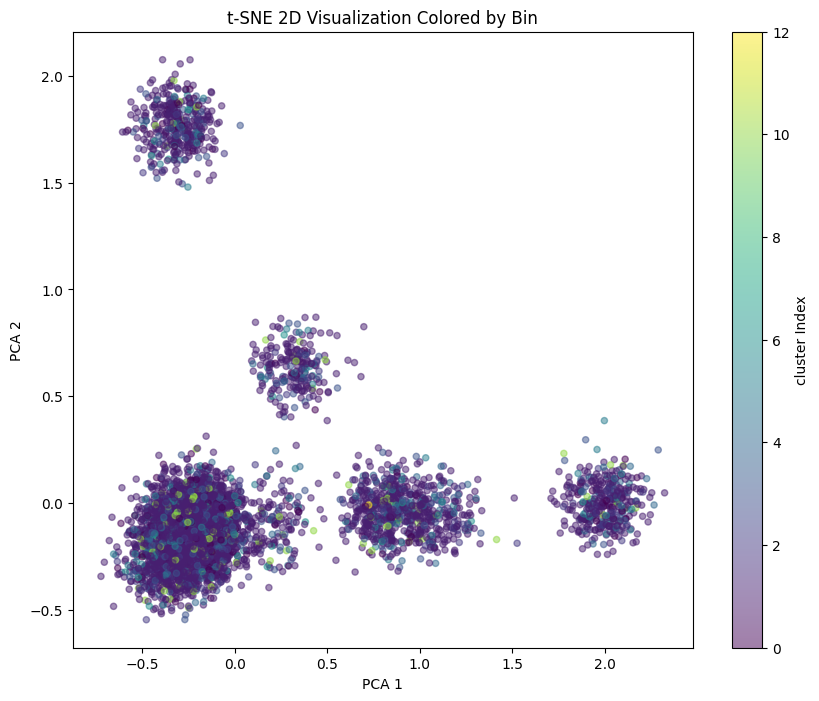

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Extract t-SNE 2D coordinates and bin labels
pca_coords = pca_embedding[:, :2]  # Use first two dimensions for 2D plot
bins = results.to_pandas()["bin"]  # Bin labels

# Convert bin labels to numerical values for coloring
# unique_bins = bins.unique()
# bin_to_color = {bin: i for i, bin in enumerate(unique_bins)}
# colors = bins.map(lambda bin: bin_to_color[bin])
colors = results.get_column("cluster")


jitter_amount = 0.1  # Adjust the jitter intensity
pca_coords_jittered = pca_coords + np.random.normal(0, jitter_amount, pca_coords.shape)
# Create scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(pca_coords_jittered[:, 0], pca_coords_jittered[:, 1], c=colors, cmap="viridis", s=20, alpha=0.5)

# Add colorbar and labels
cbar = plt.colorbar(sc)
cbar.set_label('cluster Index')
plt.title("PCA Visualization Colored by Bin")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import hdbscan

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

# Assume `matrix` is your methylation matrix
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)


# Compute k-nearest neighbors distance graph
dist_matrix = kneighbors_graph(
    matrix_scaled,  # Use scaled matrix
    n_neighbors=10,  # Adjust based on average bin size or experimentation
    mode="distance",  # Get distances instead of adjacency
    p=3,  # Euclidean distance (can adjust based on data characteristics)
    n_jobs=-1  # Use all available cores for efficiency
)

# Run HDBSCAN on the precomputed distance matrix
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5, metric="precomputed", allow_single_cluster=True)
hdbscan_labels = clusterer.fit_predict(dist_matrix.toarray()) 

In [55]:
# unique_labels = np.unique(hdbscan_labels)
np.unique(hdbscan_labels)


array([0])

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(matrix_scaled)

# Reduce to 3D for optional 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
embedding_3d = pca_3d.fit_transform(matrix_scaled)

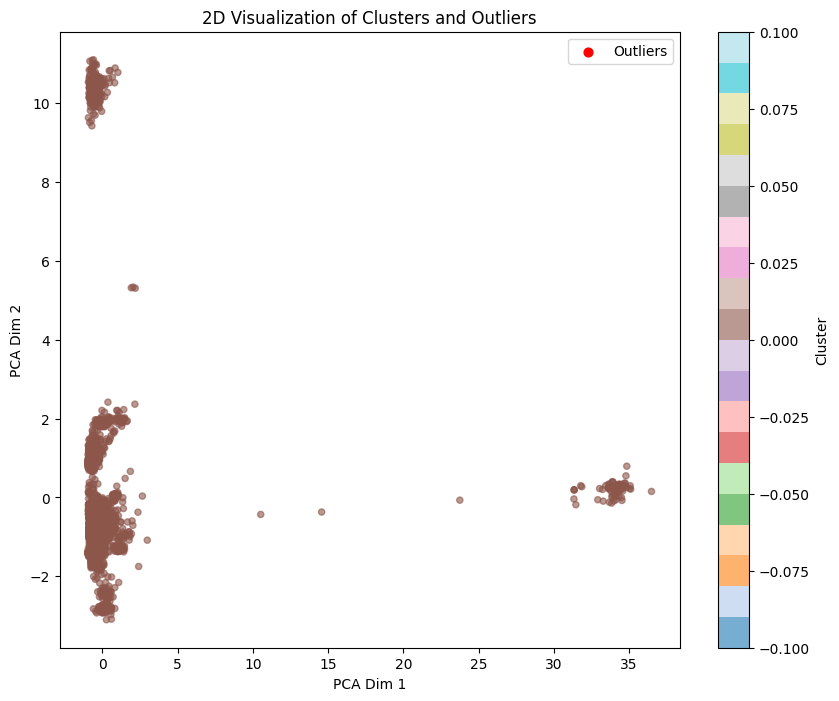

In [48]:
# Extract cluster labels
labels = hdbscan_labels

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=labels, 
    cmap="tab20",  # Use a qualitative colormap
    s=20,          # Marker size
    alpha=0.6      # Transparency
)

# Highlight outliers (label == -1) with a distinct color
outliers = (labels == -1)
plt.scatter(
    embedding_2d[outliers, 0], 
    embedding_2d[outliers, 1], 
    c="red", 
    s=40, 
    label="Outliers"
)

# Add legend and title
plt.colorbar(scatter, label="Cluster")
plt.title("2D Visualization of Clusters and Outliers")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    embedding_3d[:, 0], 
    embedding_3d[:, 1], 
    embedding_3d[:, 2], 
    c=labels, 
    cmap="tab20", 
    s=20, 
    alpha=0.6
)

# Highlight outliers
ax.scatter(
    embedding_3d[outliers, 0], 
    embedding_3d[outliers, 1], 
    embedding_3d[outliers, 2], 
    c="red", 
    s=40, 
    label="Outliers"
)

# Add title and legend
ax.set_title("3D Visualization of Clusters and Outliers")
ax.set_xlabel("PCA Dim 1")
ax.set_ylabel("PCA Dim 2")
ax.set_zlabel("PCA Dim 3")
plt.legend()
plt.show()
